# Binary logistic regression with Polya-Gamma augmentation

In [17]:
using LinearAlgebra
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/GithubRepositories/BayesianModels/Project.toml`


### Synthetic data

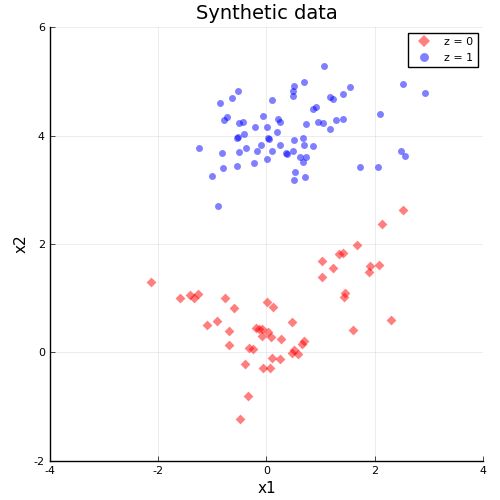

In [18]:
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]

μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 10

x1 = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2 = samplenormal(μ3, Σ3, 7  * sizecoeff)
X = hcat(x1, x2)
z = vcat(zeros(Int64, size(x1, 2)), ones(Int64, size(x2, 2)))

p = plot(
    title="Synthetic data", 
    size=(500, 500),
    xlims=(-4, 4),
    ylims=(-2, 6),
    aspect_ratio=:equal, 
    xlabel="x1", 
    ylabel="x2"
)

scatter!(
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, stroke(0))
)

scatter!(
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, stroke(0)), 
)


In [19]:
function fit!(model, X, z; nsteps = 100)
    elbos = [elbo(model, X, z) / length(z)]

    for step in 1:nsteps    
        accstats = (X, z) |> model.β.stats        
        update!(model.β.posterior, naturalparam(model.β.prior) + accstats)

        push!(elbos, elbo(model, X, z) / length(z))   
    end
    elbos
end

fit! (generic function with 1 method)

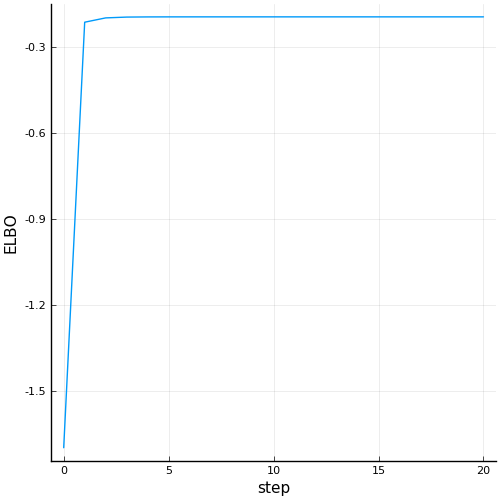

In [20]:
model = BinaryLogisticRegression(
    inputdim = size(X, 1),
    hasbias = true,
    pseudocounts = 1
)

elbos = fit!(model, X, z, nsteps = 20);

ptraining = plot(
    0:(length(elbos) - 1), elbos,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

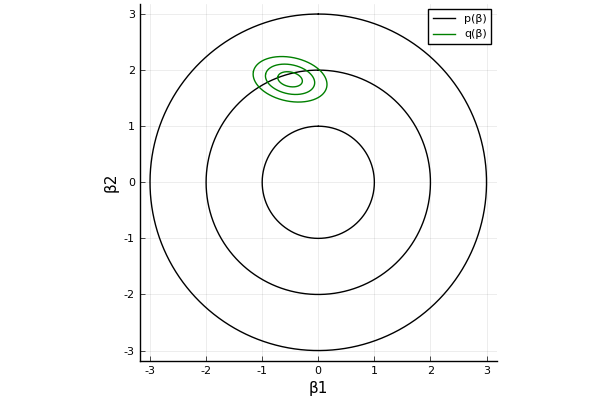

In [21]:
μ₀ = model.β.prior.μ
Σ₀ = model.β.prior.Σ
μᵦ = model.β.posterior.μ
Σᵦ = model.β.posterior.Σ

ppost = plot(
    #xlims = (-50, 50),
    #ylims = (-50, 50),
    aspect_ratio=:equal,
    xlabel = "β1",
    ylabel = "β2",
)
plotnormal2d(ppost, μ₀[1:2], Σ₀[1:2, 1:2], ncontours = 3, color = :black, label="p(β)")
plotnormal2d(ppost, μᵦ[1:2], Σᵦ[1:2, 1:2], ncontours = 3, color = :green, label="q(β)")

### Visualisation

In [22]:
function sampleβ(μ, Σ)
    L = cholesky(Σ).L
    μ .+ L * randn(length(μ))
end

function plotdecisionline!(p, w, w₀; plotting_radius=10, args...)
    # Normalize vector of weights
    norm_w = w ./ sqrt(sum(w.^2))

    # Angle of the weight vector in the range [0,2 π]
    θ = atan(w[2], w[1]) + π

    # Vector perpendicular to "w" with unit length.
    w⊥ = [cos(θ + π/2), sin(θ + π/2)]

    # Translation vector of  the decision boundary induced
    # by the bias
    shift = -(w₀ / sqrt(sum(w.^2))) * norm_w

    # Angle of the decision line in the range [0, 2π]
    α = atan(w⊥[2], w⊥[1]) + π
    
    # To get the decision line we rotate and shift the 
    # abscissa
    R = [cos(α) -sin(α); sin(α) cos(α)]
    decisionline = vcat(range(-plotting_radius, plotting_radius, length=1000)', zeros(1000)') 
    decisionline = R * decisionline .+ shift
    
    plot!(p, decisionline[1, :], decisionline[2, :]; args...)
end

plotdecisionline! (generic function with 1 method)

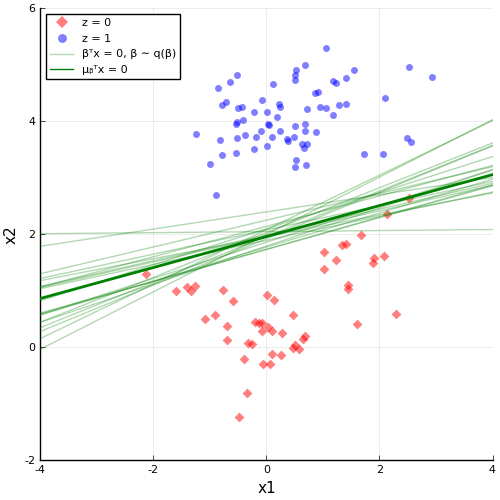

In [23]:
μᵦ = model.β.posterior.μ
Σᵦ = model.β.posterior.Σ

pdec = plot(
    size=(500, 500),
    aspect_ratio=:equal,
    xlims=(-4, 4),
    ylims=(-2, 6),
    xlabel="x1", 
    ylabel="x2"
)

scatter!(pdec,
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, 0.5, stroke(0))
)

scatter!(pdec,
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, 0.5, stroke(0)), 
)

for i in 1:20
    sβ = sampleβ(μᵦ, Σᵦ)
    w = sβ[1:2]
    w₀ = model.hasbias ? sβ[end] : 0. 
    
    label = i > 1 ? "" : "βᵀx = 0, β ∼ q(β)" 
    plotdecisionline!(pdec, w, w₀, line = (:green, 0.3), label=label)
end

w = μᵦ[1:2]
w₀ = model.hasbias ? μᵦ[end] : 0.
plotdecisionline!(pdec, w, w₀, line = (:green), linewidth=2, label="μᵦᵀx = 0")

pdec

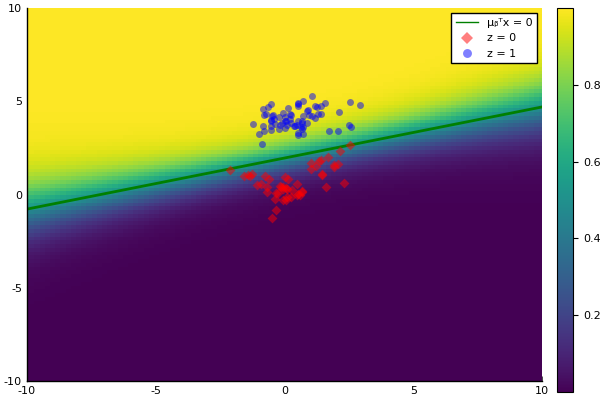

In [24]:
model 

res = 100
dim1 = range(-10, 10, length=res)
dim2 = range(-10, 10, length=res)
testX = vec([ [i, j] for i=dim1, j=dim2])
testX = hcat(testX...)

testz1 = ones(size(testX, 2))
pz1 = predict(model, testX)

pz1grid = reshape(pz1, res, res)
ppredict = heatmap(
    dim1, 
    dim2,
    pz1grid',
    xlims = (-10, 10),
    ylims = (-10, 10),
    c = :viridis
)
w = μᵦ[1:2]
w₀ = μᵦ[end]
plotdecisionline!(ppredict, w, w₀, plotting_radius=20, 
                  line = (:green), linewidth=2, label="μᵦᵀx = 0")

scatter!(ppredict,
    x1[1, :], 
    x1[2, :], 
    label="z = 0", 
    marker = (:diamond, 5, 0.5, :red, 0.5, stroke(0))
)

scatter!(ppredict,
    x2[1, :], 
    x2[2, :], 
    label="z = 1", 
    marker = (:circle, 5, 0.5, :blue, 0.5, stroke(0)), 
)